- make a classifier network that is as similar as possible to the umap subclass

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
from datetime import datetime


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels

In [7]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [8]:
labels_per_class = 3
X_labeled, Y_labeled, Y_masked = mask_labels(X_train, Y_train, labels_per_class = labels_per_class)

### Build umap graph

In [9]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [10]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [11]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [12]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 32])
batch_size

32

In [13]:
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)

In [14]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [15]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size)

### Build network

In [16]:
dims = (32,32,3)
num_classes = 2
PROJECTION_DIMS = 2
last_layer_dims = 512
lr_alpha = 0.1
dropout_rate = 0.5

In [17]:
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras import layers
def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )

In [18]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.Input(shape=dims))
### conv1a
name = '1a'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
encoder.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
encoder.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
encoder.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
encoder.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
encoder.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
encoder.add(layers.BatchNormalization(name="bn"+name))
encoder.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
encoder.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
encoder.add(layers.Flatten())
encoder.add(layers.Dense(last_layer_dims, activation=None, name='z'))

In [19]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.Input(shape=(last_layer_dims)))
encoder.add(layers.Dense(512, activation='relu'))
classifier.add(layers.Dense(num_classes, activation=None, name="predictions"))

In [20]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(last_layer_dims)))
encoder.add(layers.Dense(512, activation='relu'))
embedder.add(layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [21]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

### Create UMAP object

In [22]:
from tfumap.umap import compute_cross_entropy, convert_distance_to_probability

In [23]:
from tfumap.semisupervised import find_a_b, compute_umap_loss, compute_classifier_loss, batch_data

In [24]:
class PUMAP(tf.keras.Model):
    def __init__(
        self,
        encoder,
        embedder,
        classifier,
        tensorboard_logdir=None,  # directory for tensorboard log
        min_dist=0.1,
        negative_sample_rate=5.0,
        optimizer=tf.keras.optimizers.SGD(0.1),
        repulsion_strength=1.0,
        umap_prop=1.0, # to what extent do we train UMAP
        # ** kwargs,
    ):
        super(PUMAP, self).__init__()
        # self.__dict__.update(kwargs)

        # subnetworks
        self.embedder = embedder
        self.encoder = encoder
        self.classifier = classifier
        
        self.umap_prop = umap_prop

        # optimizer for cross entropy minimization
        self.optimizer = optimizer
        self.classifier_optimizer = tf.keras.optimizers.Adam(0.01)
        self.repulsion_strength = repulsion_strength
        self.negative_sample_rate = negative_sample_rate

        # get a,b for current min_dist
        self._a, self._b = find_a_b(min_dist)

        # create summary writer to log loss information during training
        if tensorboard_logdir is None:
            self.tensorboard_logdir = os.path.join(
                tempfile.gettempdir(),
                "tensorboard",
                datetime.now().strftime("%Y%m%d-%H%M%S"),
            )
        else:
            self.tensorboard_logdir = tensorboard_logdir
        self.summary_writer_train = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/train"
        )
        self.summary_writer_valid = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/valid"
        )

        # sparse categorical cross entropy
        self.sparse_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.create_summary_metrics()

    def create_summary_metrics(self):

        """
        Create keras summary objects for loss
        """
        self.summary_metrics = {}
        self.summary_metrics["train_loss_umap"] = tf.keras.metrics.Mean(
            "train_loss_umap", dtype=tf.float32
        )
        self.summary_metrics["train_loss_classif"] = tf.keras.metrics.Mean(
            "train_loss_classif", dtype=tf.float32
        )
        self.summary_metrics["valid_loss_classif"] = tf.keras.metrics.Mean(
            "valid_loss_classif", dtype=tf.float32
        )
        self.summary_metrics["train_acc_classif"] = tf.keras.metrics.Accuracy(
            "train_acc_classif", dtype=tf.float32
        )
        self.summary_metrics["valid_acc_classif"] = tf.keras.metrics.Accuracy(
            "valid_acc_classif", dtype=tf.float32
        )

    def write_acc(self, X, y, batch, train=True):
        predictions = self.classify_data(X)

        if train:
            summary_writer = self.summary_writer_train
            train_valid = "train"
        else:
            summary_writer = self.summary_writer_valid
            train_valid = "valid"

        self.summary_metrics[train_valid + "_acc_classif"].update_state(predictions, y)

        # write loss
        with summary_writer.as_default():
            tf.summary.scalar(
                "acc_classif",
                self.summary_metrics[train_valid + "_acc_classif"].result(),
                step=batch,
            )
            summary_writer.flush()

    def write_losses(self, batch, classif_loss, umap_loss=None, train=True):
        # add umap loss
        if train:
            summary_writer = self.summary_writer_train
            train_valid = "train"
            self.summary_metrics[train_valid + "_loss_umap"](umap_loss)
        else:
            summary_writer = self.summary_writer_valid
            train_valid = "valid"

        # add valid loss
        self.summary_metrics[train_valid + "_loss_classif"](classif_loss)

        # write loss
        with summary_writer.as_default():
            if train:
                tf.summary.scalar(
                    "umap_loss",
                    self.summary_metrics[train_valid + "_loss_umap"].result(),
                    step=batch,
                )
            tf.summary.scalar(
                "classif_loss",
                self.summary_metrics[train_valid + "_loss_classif"].result(),
                step=batch,
            )
            summary_writer.flush()

    @tf.function
    def train(self, batch_to, batch_from, X, y, save_loss=False):
        """ One training step 
        Input are points and weights for positive and negative 
        samples for training. 
            
        """
        with tf.GradientTape() as tape:
            (attraction_loss, repellant_loss, umap_loss) = compute_umap_loss(
                batch_to,
                batch_from,
                self.embedder,
                self.encoder,
                self._a,
                self._b,
                self.negative_sample_rate,
                self.repulsion_strength,
            )

            classifier_loss = compute_classifier_loss(
                X, y, self.encoder, self.classifier, self.sparse_ce
            )
            loss = tf.reduce_sum(classifier_loss)  + tf.reduce_sum(umap_loss)*self.umap_prop

        # compute gradient for umap
        grad = tape.gradient(
            loss,
            self.encoder.trainable_variables
            + self.embedder.trainable_variables
            + self.classifier.trainable_variables,
        )

        # gradients are cliped in UMAP implementation. Any effect here?
        grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in grad]

        self.optimizer.apply_gradients(
            zip(
                grad,
                self.encoder.trainable_variables
                + self.embedder.trainable_variables
                + self.classifier.trainable_variables,
            )
        )

        return (attraction_loss, repellant_loss, umap_loss, classifier_loss)

    # @tf.function
    def project_epoch(self, X):
        """ Train a batch in tensorflow
        """
        return [self.embedder(self.encoder(batch)) for batch in X]

    def get_dataset_loss(self, dataset):
        return [
            compute_classifier_loss(X, y, self.encoder, self.classifier, self.sparse_ce)
            for X, y in dataset
        ]

    def classify_data(self, X):
        """ Classify a set of points X
        """
        X_batch = batch_data(X, batch_size=100)
        predictions = tf.concat([classifier(encoder(i)) for i in tqdm(X_batch)], axis=0)
        predictions = tf.nn.softmax(predictions) 
        return tf.argmax(predictions, 1)  

In [25]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-2), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
)

### plotting results

In [26]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


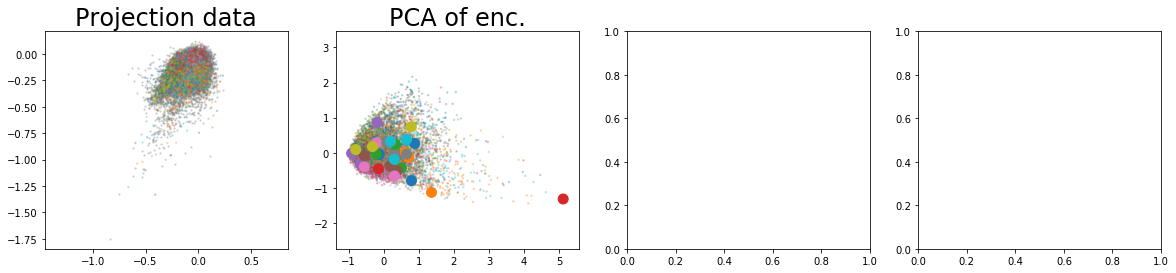

In [27]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [28]:
batch = 0; epoch = 0
N_EPOCHS = 50 # total number of epochs
SAMPLE_EPOCHS = np.linspace(0, N_EPOCHS-1, 10).astype('int') # how often to plot
print(SAMPLE_EPOCHS[:10])
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)
TOTAL_BATCHES = BATCHES_PER_EPOCH * N_EPOCHS

[ 0  5 10 16 21 27 32 38 43 49]


In [29]:
#z_valid = UMAP(verbose=True).fit_transform(latent_valid.numpy())

In [30]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    break

In [31]:
# validation loss
classif_loss = model.get_dataset_loss(data_valid)

In [32]:
for (batch_to, batch_from), (X, y) in tqdm(
        zip(edge_epoch, labeled_iter), total=BATCHES_PER_EPOCH, leave=False
    ):
    break

In [35]:
batch_to = X_train[batch_to]
batch_from = X_train[batch_from]

In [37]:
umap_loss = compute_umap_loss(
                batch_to,
                batch_from,
                model.embedder,
                model.encoder,
                model._a,
                model._b,
                model.negative_sample_rate,
                model.repulsion_strength,
)

In [40]:
len(umap_loss)

3

In [44]:
umap_loss[-1].shape, 32*6

(TensorShape([192]), 192)

In [ ]:

def compute_classifier_loss(X, y, encoder, classifier, sparse_ce):
    """ compute the cross entropy loss for classification
        """
    X_batch = batch_data(X)
    d = tf.stack([classifier(encoder(i)) for i in X_batch])
    return sparse_ce(y, d)

In [47]:
model.classifier(model.encoder(X))

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[-0.14364576,  0.27376747],
       [-0.05291472,  0.1696451 ],
       [-0.02237374,  0.20242882],
       [-0.0443465 ,  0.29429698],
       [-0.11149676,  0.16101725],
       [-0.19555777, -0.01301707],
       [-0.19555777, -0.01301707],
       [-0.10618984,  0.2636382 ],
       [-0.04385821,  0.23351851],
       [ 0.04168122,  0.15338631],
       [ 0.01900358,  0.11690195],
       [-0.02838288,  0.15956837],
       [-0.68367714,  0.07809932],
       [-0.02838288,  0.15956837],
       [-0.10618984,  0.2636382 ],
       [-0.05209009,  0.21963006],
       [ 0.01900358,  0.11690195],
       [ 0.00297785,  0.2738449 ],
       [-0.09961437,  0.2464745 ],
       [ 0.00594048,  0.21843028],
       [-0.02172633,  0.10099702],
       [-0.11979294,  0.14899085],
       [-0.15060887,  0.3012724 ],
       [-0.07617679,  0.26826277],
       [-0.15060887,  0.3012724 ],
       [-0.04447611,  0.28208905],
       [-0.10810585,  0.1792762 ],
      

In [45]:
compute_classifier_loss(
    X, y, model.encoder, model.classifier, model.sparse_ce
)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [ ]:
model.train(batch_to=batch_to, batch_from=batch_from, X=X, y=y)

In [ ]:
breakme

In [ ]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    
    # validation loss
    classif_loss = model.get_dataset_loss(data_valid)
    model.write_losses(
            batch=batch, classif_loss=classif_loss, umap_loss=None, train=False
        )
    model.write_acc(X_valid, Y_valid, batch, train=False)
    model.write_acc(X_labeled, Y_labeled, batch, train=True)
    
    # train
    for (batch_to, batch_from), (X, y) in tqdm(
        zip(edge_epoch, labeled_iter), total=BATCHES_PER_EPOCH, leave=False
    ):
        batch_to = X_train[batch_to]
        batch_from = X_train[batch_from]
        # train model
        losses = model.train(batch_to=batch_to, batch_from=batch_from, X=X, y=y)
        model.write_losses(
            batch=batch, classif_loss=losses[3], umap_loss=losses[2], train=True
        )
    # plot
    if epoch in SAMPLE_EPOCHS:
        print("batch: {}".format(batch))
        plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size)
    batch += BATCHES_PER_EPOCH
    # batch_tqdm.update(BATCHES_PER_EPOCH)

In [ ]:
%debug